In [1]:
# python utilities
import random
import os
import datetime
import pickle

# general data science
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# ---------- scikit-learn ------------
# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# model selection
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model evaluation
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score 
# from sklearn.metrics import precision_score, recall_score
# -------------------------------------

# imbalanced-learn
from imblearn.pipeline import Pipeline # if using imblearn's sampling we must use this over sklearn's Pipeline 
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE, RandomOverSampler # oversampling
# from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, NearMiss, RandomUnderSampler # undersampling

import warnings  
warnings.filterwarnings('ignore')

def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything()

In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [5]:
df_train = pd.read_csv("train1.csv")
df_val = pd.read_csv("val1.csv")
df_test = pd.read_csv("test1.csv")
df_train.shape, df_val.shape, df_test.shape

((16260, 62), (4001, 62), (89784, 62))

In [3]:
df_train.head()

,loan_amnt,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,zip_code,addr_state,dti,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,profit
0,5300.0,< 1 year,RENT,34750.0,2012-12-01,Fully Paid,credit_card,959xx,CA,12.47,...,0.0,0.0,100.0,100.0,0.0,15900.0,12283.0,12100.0,0.0,1575.849997
1,9000.0,2 years,RENT,60000.0,2012-09-01,Fully Paid,credit_card,986xx,WA,22.44,...,0.0,5.0,97.0,50.0,0.0,94311.0,71192.0,8000.0,72511.0,307.923808
2,12000.0,10+ years,RENT,95000.0,2012-10-01,Fully Paid,debt_consolidation,900xx,CA,16.12,...,0.0,1.0,100.0,33.3,0.0,79780.0,47431.0,29100.0,44180.0,262.697370
3,5500.0,8 years,RENT,20000.0,2012-11-01,Fully Paid,medical,734xx,OK,27.00,...,0.0,7.0,100.0,75.0,0.0,20530.0,7069.0,7300.0,6430.0,1298.946425
4,6000.0,2 years,RENT,110000.0,2012-11-01,Charged Off,credit_card,346xx,FL,25.07,...,1.0,0.0,88.0,100.0,0.0,100804.0,65137.0,28800.0,66504.0,-3519.260000


In [4]:
X_train, y_train, profit_train = df_train.drop(["loan_status", "profit"], axis=1), df_train["loan_status"], df_train["profit"]

# encode loan status
y_train = y_train.replace({"Charged Off":1, "Fully Paid":0})

## Preprocessing

### Missing values (a quick look)
We'll do imputation later on.

In [6]:
missing = X_train.isna().mean().sort_values(ascending=False)
print("Columns without missing values:", missing[missing==0].shape[0])
print("Columns with missing values:", missing[missing>0].shape[0])
missing[missing>0]

Columns without missing values: 25
Columns with missing values: 35


mths_since_last_record            0.974600
mths_since_last_major_derog       0.788007
mths_since_recent_bc_dlq          0.736470
mths_since_recent_revol_delinq    0.652829
mths_since_last_delinq            0.509041
mths_since_recent_inq             0.129951
mo_sin_old_il_acct                0.054428
emp_length                        0.043419
bc_util                           0.010394
bc_open_to_buy                    0.009779
percent_bc_gt_75                  0.009779
mths_since_recent_bc              0.008241
mo_sin_old_rev_tl_op              0.003075
mo_sin_rcnt_rev_tl_op             0.003075
total_rev_hi_lim                  0.003014
num_accts_ever_120_pd             0.003014
tot_cur_bal                       0.003014
mo_sin_rcnt_tl                    0.003014
tot_coll_amt                      0.003014
avg_cur_bal                       0.003014
total_il_high_credit_limit        0.003014
num_actv_bc_tl                    0.003014
num_tl_30dpd                      0.003014
tot_hi_cred

### Categorical columns

In [4]:
obj_cols = X_train.columns[X_train.dtypes=="object"]

In [208]:
X_train[obj_cols].head()

,emp_length,home_ownership,issue_d,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status
0,< 1 year,RENT,2012-12-01,credit_card,959xx,CA,2004-05-01,w
1,2 years,RENT,2012-09-01,credit_card,986xx,WA,1999-09-01,f
2,10+ years,RENT,2012-10-01,debt_consolidation,900xx,CA,1996-12-01,f
3,8 years,RENT,2012-11-01,medical,734xx,OK,2005-01-01,w
4,2 years,RENT,2012-11-01,credit_card,346xx,FL,1998-05-01,f


In [210]:
X_train[obj_cols].nunique()

emp_length              11
home_ownership           5
issue_d                  4
purpose                 13
zip_code               760
addr_state              44
earliest_cr_line       499
initial_list_status      2
dtype: int64

In [211]:
missing_obj = missing[obj_cols]
missing_obj[missing_obj > 0]

emp_length    0.043419
dtype: float64

- We will convert `emp_length` to an ordinal variable. 
- We will convert `issue_d` and `earliest_cr_line` to dates -- we will replace `issue_d` with the number of months since 2000-01-01 (an arbitrarily chosen reference point) and we will replace `earliest_cr_line` with the difference: `earliest_cr_line` - `issue_d`, in months. If we expected seasonality to be important, we could record the month part of each date, but from our EDA we do not think this will help.
- We will use target encoding for `zip_code` since it has high cardinality.
- We will use one-hot encoding for `home_ownership`, `purpose`, `addr_state`, `initial_list_status`.

- For imputation, we will impute `emp_length`, `issue_d`, `earliest_cr_line`, and `zip_code` using the median value after converting to numeric. For `home_ownership`, `purpose`, `addr_state`, and `initial_list_status` we will impute these with the mode.

In [212]:
# encode emp_length
lookup = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, 
          '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years':10}
X_train["emp_length"] = X_train["emp_length"].replace(lookup)

# issue date
X_train["issue_d"] = pd.to_datetime(X_train["issue_d"])
tmp = X_train["issue_d"].values # keep a copy of the raw date for when we transform earliest credit line
X_train["issue_d"] = (X_train["issue_d"]-datetime.datetime(2000,1,1)).astype('timedelta64[M]')

# earliest credit line
X_train["earliest_cr_line"] = pd.to_datetime(X_train["earliest_cr_line"])
X_train["earliest_cr_line"] = (tmp - X_train["earliest_cr_line"]).astype('timedelta64[M]')

# imputation for home_ownership, purpose, addr_state, and initial_list_status
cat_cols = ['home_ownership', 'purpose', 'addr_state', 'initial_list_status']
mode_imputer = SimpleImputer(strategy="most_frequent")
X_train[cat_cols] = mode_imputer.fit_transform(X_train[cat_cols])

# encode zip code
te_zip = TargetEncoder()
X_train["zip_code"] = te_zip.fit_transform(X_train["zip_code"], y_train)

In [213]:
X_train[obj_cols].isna().sum()

emp_length             706
home_ownership           0
issue_d                  0
purpose                  0
zip_code                 0
addr_state               0
earliest_cr_line         0
initial_list_status      0
dtype: int64

Let's define a pipeline for our categorical preprocessing.

In [6]:
class CategoricalPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mode_imputer = SimpleImputer(strategy="most_frequent")
        self.cat_cols = ['home_ownership', 'purpose', 'addr_state', 'initial_list_status']
        self.target_encoder = TargetEncoder(handle_missing='return_nan', handle_unknown='return_nan')
    
    def fit(self, X, y=None):
        self.mode_imputer.fit(X[self.cat_cols])
        self.target_encoder.fit(X["zip_code"], y)
        return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        
       # encode emp_length
        lookup = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, 
                  '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years':10}
        Xc["emp_length"] = Xc["emp_length"].replace(lookup)

        # issue date
        Xc["issue_d"] = pd.to_datetime(Xc["issue_d"])
        tmp = Xc["issue_d"].values # keep a copy of the raw date for when we transform earliest credit line
        Xc["issue_d"] = (Xc["issue_d"]-datetime.datetime(2000,1,1)).astype('timedelta64[M]')

        # earliest credit line
        Xc["earliest_cr_line"] = pd.to_datetime(Xc["earliest_cr_line"])
        Xc["earliest_cr_line"] = (tmp - Xc["earliest_cr_line"]).astype('timedelta64[M]')
        
        # imputation for home_ownership, purpose, addr_state, and initial_list_status
        Xc[self.cat_cols] = self.mode_imputer.transform(Xc[self.cat_cols])
        
        # encode zip code
        Xc["zip_code"] = self.target_encoder.transform(Xc["zip_code"])
        
        return Xc
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

### Numeric columns

In [8]:
num_cols = X_train.columns[X_train.dtypes!="object"]
X_train[num_cols].dtypes

loan_amnt                         float64
emp_length                        float64
annual_inc                        float64
issue_d                           float64
zip_code                          float64
dti                               float64
delinq_2yrs                       float64
earliest_cr_line                  float64
fico_range_low                    float64
fico_range_high                   float64
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          float64
pub_rec                           float64
revol_bal                         float64
revol_util                        float64
total_acc                         float64
mths_since_last_major_derog       float64
tot_coll_amt                      float64
tot_cur_bal                       float64
total_rev_hi_lim                  float64
acc_open_past_24mths              float64
avg_cur_bal                       

For columns prefixed with `mths_since` or `mo_sin` (representing months since some event occurred -- or "NA" if the event has never occurred), we are going to use a method applied in similar projects [[1](https://towardsdatascience.com/intelligent-loan-selection-for-peer-to-peer-lending-575dfa2573cb#a0a0),[2](https://www.kaggle.com/tywmick/building-a-neural-network-to-predict-loan-risk/notebook)] which is to take the reciprocol. This allows us to give a numeric value to the "NA" entries; we just treat these as $1/\infty = 0$. If the value is originally 0, then to prevent division by zero we'll just call this 1.

An alternative solution would be to treat "NA" as whatever the maximum is in the data; however, then we cannot distinguish "perfect records" from records with delinquencies long ago. We could also treat these columns as categorical and bin non-null values -- but then we lose the ordering.

In [215]:
mo_sin = [x for x in X_train.columns if "mo_sin" in x or "mths_since" in x]

for col in mo_sin:
    X_train[col] = X_train[col].apply(lambda x: 0 if np.isnan(x) else 1/max(x,1))

X_train[mo_sin]

,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq
0,0.000000,0.0,0.000000,0.000000,0.009524,0.055556,0.055556,0.055556,0.000000,0.055556,0.000000
1,0.083333,0.0,0.000000,0.006369,0.006711,0.200000,0.200000,0.043478,0.000000,0.166667,0.000000
2,0.000000,0.0,0.000000,0.005208,0.009901,0.013333,0.111111,0.012195,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.029412,0.010526,1.000000,1.000000,0.500000,0.000000,1.000000,0.000000
4,0.090909,0.0,0.090909,0.005650,0.007042,0.024390,0.045455,0.024390,0.071429,0.071429,0.071429
...,...,...,...,...,...,...,...,...,...,...,...
16255,0.000000,0.0,0.000000,0.008333,0.006667,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
16256,0.012987,0.0,0.000000,0.000000,0.005952,0.090909,0.090909,0.013889,0.012987,0.000000,0.012987
16257,0.166667,0.0,0.000000,0.142857,0.005181,0.083333,0.142857,0.035714,0.166667,0.142857,0.166667
16258,0.100000,0.0,0.000000,0.013699,0.007407,0.018519,0.125000,0.016667,0.000000,0.125000,0.000000


In [217]:
X_train[mo_sin].isna().sum()

mths_since_last_delinq            0
mths_since_last_record            0
mths_since_last_major_derog       0
mo_sin_old_il_acct                0
mo_sin_old_rev_tl_op              0
mo_sin_rcnt_rev_tl_op             0
mo_sin_rcnt_tl                    0
mths_since_recent_bc              0
mths_since_recent_bc_dlq          0
mths_since_recent_inq             0
mths_since_recent_revol_delinq    0
dtype: int64

In [218]:
other_num_cols = [x for x in num_cols if x not in mo_sin]
print(other_num_cols)

['loan_amnt', 'emp_length', 'annual_inc', 'issue_d', 'zip_code', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']


In [220]:
missing_other_num = missing[other_num_cols]
missing_other_num[missing_other_num>0]

emp_length                    0.043419
revol_util                    0.000677
tot_coll_amt                  0.003014
tot_cur_bal                   0.003014
total_rev_hi_lim              0.003014
avg_cur_bal                   0.003014
bc_open_to_buy                0.009779
bc_util                       0.010394
num_accts_ever_120_pd         0.003014
num_actv_bc_tl                0.003014
num_actv_rev_tl               0.003014
num_bc_tl                     0.003014
num_il_tl                     0.003014
num_op_rev_tl                 0.003014
num_rev_accts                 0.003014
num_rev_tl_bal_gt_0           0.003014
num_tl_120dpd_2m              0.003014
num_tl_30dpd                  0.003014
num_tl_90g_dpd_24m            0.003014
num_tl_op_past_12m            0.003014
pct_tl_nvr_dlq                0.003014
percent_bc_gt_75              0.009779
tot_hi_cred_lim               0.003014
total_il_high_credit_limit    0.003014
dtype: float64

For the rest of the numeric values, which mostly represent counts (e.g. number of accounts) or monetary values/totals (e.g. loant amount, annual income, total bankcard limit), we will use a simple median imputation because there are very few missing values.

In [224]:
impute_cols = missing_other_num[missing_other_num>0].index
median_imputer = SimpleImputer(strategy="median")
X_train[impute_cols] = median_imputer.fit_transform(X_train[impute_cols])

In [226]:
X_train.isna().sum()

loan_amnt                         0
emp_length                        0
home_ownership                    0
annual_inc                        0
issue_d                           0
purpose                           0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    0
mths_since_last_delinq            0
mths_since_last_record            0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
initial_list_status               0
mths_since_last_major_derog       0
tot_coll_amt                      0
tot_cur_bal                       0
total_rev_hi_lim                  0
acc_open_past_24mths              0
avg_cur_bal                 

Let's define a pipeline for our numerical preprocessing.

In [7]:
class NumericalPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_imputer = SimpleImputer(strategy="median")
    
    def fit(self, X, y=None):
        self.num_cols = X.columns[X.dtypes!="object"]
        self.mo_sin_cols = [x for x in X.columns if "mo_sin" in x or "mths_since" in x]
        self.other_num_cols = [x for x in self.num_cols if x not in self.mo_sin_cols]
        self.median_imputer.fit(X[self.other_num_cols])
        return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        
        for col in self.mo_sin_cols:
            Xc[col] = Xc[col].apply(lambda x: 0 if np.isnan(x) else 1/max(x,1))
            
        Xc[self.other_num_cols] = self.median_imputer.transform(Xc[self.other_num_cols])
        
        return Xc
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

## Categorical encoding and numeric re-scaling
Here we just instantiate them.

In [534]:
ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

## Feature selection
Let's perform feature selection using "filter" methods (i.e. based on correlations & statistical tests between predictors and the target). We have three steps to consider:
1. Remove variables which are highly correlated -- this generally helps models learn better
2. Remove numerical variables which are not predictive
3. Remove categorical variables which are not predictive

#### Multicollinearity

In [508]:
# https://stackoverflow.com/a/49282823/7638741
threshold=0.8
X_corr = X_train.corr()
X_not_correlated = ~(X_corr.mask(np.tril(np.ones([len(X_corr)]*2, dtype=bool))).abs() > threshold).any() 
un_corr_idx = X_not_correlated.loc[X_not_correlated[X_not_correlated.index]].index.values.tolist()

cat_cols = X_train.columns[X_train.dtypes == "object"].values.tolist()
X_train = X_train[un_corr_idx + cat_cols]

#### Numeric variables

In [103]:
num_cols = X_train.columns[X_train.dtypes!="object"]
selector = SelectKBest(f_classif, k=10)
selector.fit_transform(X_train[num_cols], y_train)

array([[7.14285714e-02, 6.65000000e+02, 6.69000000e+02, ...,
        1.00000000e+02, 1.59000000e+04, 1.21000000e+04],
       [1.75000000e-01, 6.60000000e+02, 6.64000000e+02, ...,
        5.00000000e+01, 9.43110000e+04, 8.00000000e+03],
       [1.37566138e-01, 7.15000000e+02, 7.19000000e+02, ...,
        3.33000000e+01, 7.97800000e+04, 2.91000000e+04],
       ...,
       [9.09108549e-02, 6.85000000e+02, 6.89000000e+02, ...,
        2.00000000e+01, 3.54000000e+04, 1.94000000e+04],
       [1.21052632e-01, 6.70000000e+02, 6.74000000e+02, ...,
        6.67000000e+01, 5.05240000e+04, 1.47000000e+04],
       [1.27659574e-01, 7.05000000e+02, 7.09000000e+02, ...,
        4.00000000e+01, 4.46887000e+05, 1.83000000e+04]])

In [111]:
num_cols[selector.get_support()]

Index(['zip_code', 'fico_range_low', 'fico_range_high', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'bc_open_to_buy', 'num_tl_op_past_12m',
       'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit'],
      dtype='object')

In [89]:
df_sel = pd.DataFrame({"cols":num_cols, "pvals":selector.pvalues_}).sort_values("pvals", ascending=False)
df_sel.loc[df_sel["pvals"] > 0.1]

,cols,pvals
42,num_rev_accts,0.882098
18,mths_since_last_major_derog,0.730847
38,num_bc_sats,0.724688
49,pct_tl_nvr_dlq,0.695098
6,delinq_2yrs,0.620313
34,mths_since_recent_revol_delinq,0.615790
47,num_tl_90g_dpd_24m,0.614392
13,open_acc,0.517445
44,num_sats,0.515624
45,num_tl_120dpd_2m,0.503587


#### Categorical variables

In [514]:
selector = SelectKBest(lambda X,y: mutual_info_classif(X, y, discrete_features=True), k="all")
selector.fit(ohe.fit_transform(X_train[cat_cols]), y_train)

<16260x64 sparse matrix of type '<class 'numpy.float64'>'
	with 65040 stored elements in Compressed Sparse Row format>

In [529]:
df_sel = pd.DataFrame({"cols":ohe.get_feature_names(), "score":selector.scores_}).sort_values("score", ascending=True)
df_sel.head(10)

,cols,score
24,x2_CT,1.550599e-08
61,x2_WY,3.394466e-08
55,x2_UT,2.006534e-07
52,x2_SC,2.060913e-07
34,x2_LA,2.784784e-07
26,x2_DE,5.182606e-07
1,x0_NONE,1.273302e-06
9,x1_house,1.394695e-06
20,x2_AR,1.800109e-06
35,x2_MA,1.817059e-06


Let's define a pipeline for this. Note we've changed things slightly -- now we first one-hot encode and consider multicollinearity of categorical variables as well (this is supposedly a good idea in practice).

In [8]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, max_corr=1, k_num=1, k_cat=1):
        self.max_corr = max_corr
        self.k_num = k_num
        self.k_cat = k_cat
        self.ohe = OneHotEncoder(handle_unknown='ignore')
        self.scaler = StandardScaler()
        self.num_cols = None
        self.cat_cols = None
        self.cat_cols_enc = None
        self.all_cols = None
        
    def fit(self, X, y=None):
        Xc = X.copy()
        yc = y.copy()
        
        # identify numeric and categorical columns
        self.num_cols = Xc.columns[Xc.dtypes!="object"].values
        self.cat_cols = Xc.columns[Xc.dtypes=="object"].values
        
        # one-hot-encode categorical columns and convert back to full dataframe
        Xc_cat = self.ohe.fit_transform(Xc[self.cat_cols]).toarray()
        self.cat_cols_enc = self.ohe.get_feature_names(input_features=self.cat_cols)
        Xc_cat = pd.DataFrame(Xc_cat, columns = self.cat_cols_enc)
        Xc_num = Xc[self.num_cols]
        Xc = pd.concat([Xc_cat, Xc_num], axis=1)
        
        # handling multicollinearity
        if self.max_corr < 1:
            X_corr = Xc.corr()
            X_not_correlated = ~(X_corr.mask(np.tril(np.ones([len(X_corr)]*2, dtype=bool))).abs() > self.max_corr).any() 
            un_corr_idx = X_not_correlated.loc[X_not_correlated[X_not_correlated.index]].index.values
            Xc = Xc[un_corr_idx]
            self.cat_cols_enc = np.array([c for c in Xc.columns if c in self.cat_cols_enc])
            self.num_cols = np.array([c for c in Xc.columns if c in self.num_cols])
        
        # numeric feature selection
        n_feats = int(self.k_num*len(self.num_cols))
        if self.k_num < 1 and n_feats > 0:
            num_selector = SelectKBest(f_classif, k=n_feats)
            num_selector.fit(Xc[self.num_cols], yc)
            self.num_cols = self.num_cols[num_selector.get_support()]
            Xc = Xc[self.cat_cols_enc.tolist() + self.num_cols.tolist()]
        
        # categorical feature selection
        n_feats = int(self.k_cat*len(self.cat_cols_enc))
        if self.k_cat < 1 and n_feats > 0:
            cat_selector = SelectKBest(lambda X,y: mutual_info_classif(X, y, discrete_features=True), k=n_feats)
            cat_selector.fit(Xc[self.cat_cols_enc], yc)
            self.cat_cols_enc = self.cat_cols_enc[cat_selector.get_support()]
            Xc = Xc[self.cat_cols_enc.tolist() + self.num_cols.tolist()]
        
        # all selected features
        self.all_cols = self.cat_cols_enc.tolist() + self.num_cols.tolist()
        
        # fit numeric scaler
        self.scaler.fit(Xc[self.all_cols])
                
        return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        Xc_cat = self.ohe.transform(Xc[self.cat_cols]).toarray()
        Xc_cat = pd.DataFrame(Xc_cat, columns = self.ohe.get_feature_names(input_features=self.cat_cols))
        Xc_num = Xc[self.num_cols]
        Xc = pd.concat([Xc_cat, Xc_num], axis=1)
        Xc = pd.DataFrame(self.scaler.transform(Xc[self.all_cols]), columns = self.all_cols)
        
        return Xc
    
    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X,y)

## Modeling
We now fit several machine learning models to our training data. We use `GridSearchCV` (with our hold-out validation set) to identify the best hyperparameters. We use log loss (a good second choice is "Brier score") as our scoring metric during grid search. The reason for this choice of metric is that in loan default prediction we care a lot about our probabilities being well-calibrated. Indeed, one can achieve 100% ROC-AUC while always predicting probabilities as 51%,49% because ROC-AUC only cares about correct rankings.

After the best hyperparameters have been chosen according to log loss, we report several other metrics of our validation set: Brier score, typical confusion matrix metrics (precision, recall, F1), PR-AUC (also called average precision), and ROC-AUC. We define a custom metric "Expected Misclassification Cost" (EMC) which we define as
$$EMC(C) = C\cdot FN + FP$$
where $FN$ is the number of false negatives, $FP$ is the number of false positives, and $C$ is a parameter which specifies how many times more costly one false negative is compared to one false positive.

### Set up

We need to re-load the training data because we modified it above. We will instead be performing feature selection within a `GridSearchCV` pipeline. We also load in the validation and testing data.

In [9]:
X_train, y_train, profit_train = df_train.drop(["loan_status", "profit"], axis=1), df_train["loan_status"], df_train["profit"]
X_val, y_val, profit_val = df_val.drop(["loan_status", "profit"], axis=1), df_val["loan_status"], df_val["profit"]
X_test, y_test, profit_test = df_test.drop(["loan_status", "profit"], axis=1), df_test["loan_status"], df_test["profit"]

# encode loan status
y_train = y_train.replace({"Charged Off":1, "Fully Paid":0})
y_val = y_val.replace({"Charged Off":1, "Fully Paid":0})
y_test = y_test.replace({"Charged Off":1, "Fully Paid":0})

del df_train, df_val, df_test

Perform preprocessing steps that can occur outside `GridSearchCV` (not dependent on any parameters).

In [10]:
pipe = Pipeline([('cat_proc', CategoricalPreprocessing()),
                 ('num_proc', NumericalPreprocessing())])

X_train = pipe.fit_transform(X_train, y_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

pickle.dump(pipe, open("preproc_pipeline.pkl", 'wb'))

Here we define our `GridSearchCV` pipeline. This can optionally take a re-sampling method (`sm`).

In [11]:
def fit_model(model, param_grid, X_train, y_train, X_val, y_val, sm=None, fit_to_val=True, random=False):
    # instantiate base pipeline
    if sm:
        steps = [('feat_proc', FeatureSelection()), ("sampling", sm), ("clf", model)]
    else:
        steps = [('feat_proc', FeatureSelection()), ("clf", model)]
    pipe = Pipeline(steps)
    
    # make a predefined validation split
    X_tv = pd.concat([X_train, X_val], axis=0)
    y_tv = pd.concat([y_train, y_val], axis=0)
    tv_idx = [-1]*len(X_train) + [0]*len(X_val) # a list where train data indices are -1 and validation data indices are 0
    ps = PredefinedSplit(test_fold = tv_idx)
    
    # grid search
    if random:
        grid = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=ps, scoring='neg_log_loss', verbose=10, refit=fit_to_val)
    else:
        grid = GridSearchCV(pipe, param_grid=param_grid, cv=ps, scoring='neg_log_loss', verbose=10, refit=fit_to_val)
    grid.fit(X_tv, y_tv) 
    
    # we may not want to refit on the combined training+validation set (esp. if doing out-of-time validation)
    # if we do, then we return grid.best_estimator_
    if fit_to_val:
        return grid.best_estimator_
    
    else:
        # If not, we can take the best estimator and refit manually on X_train only. 
        # Note: grid.best_estimator_ is not instantiated if refit=False, so we have to manually set the parameters.
        bp = grid.best_params_ # get best parameters
        for p in bp: # set parameters of base pipeline to `bp`
            step, param = p.split("__")
            setattr(pipe[step], param, bp[p]) 
        pipe.fit(X_train, y_train) # refit to X_train
        return pipe

Define a function for printing a model evaluation report.

In [12]:
def eval_model(pipe, X, y, plot_pr=True, plot_roc=True):
    y_proba = pipe.predict_proba(X)[:,1]
    n_plots = plot_pr + plot_roc # calculate number of plots
    if n_plots > 0:
        fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*6, 4))
        curr_ax = 0
        if n_plots == 1:
            ax = [ax]
            
    # Log-loss
    LL = log_loss(y, y_proba)
    
    # Brier score
    BS = brier_score_loss(y, y_proba)
    
    # Precision, recall, f1
    y_pred = pipe.predict(X)
#     P = precision_score(y, y_pred)
#     R = recall_score(y, y_pred)
#     F1 = 2*P*R/(P+R)

    # expected misclassification cost
    EMCs = {}
    for c in [1, 5, 10, 50]:
        FP = len(np.where(np.logical_and(y_pred==1, y==0))[0])
        FN = len(np.where(np.logical_and(y_pred==0, y==1))[0])
        EMCs["EMC (C=%i)" % c] = c*FN + FP
    
    # PR curve
    AP = average_precision_score(y, y_proba)
    if plot_pr:
        plt.sca(ax[curr_ax])
        curr_ax += 1
        precision, recall, thresholds = precision_recall_curve(y, y_proba)
        plt.plot(precision, recall, lw=1, label='AP = %0.2f'% AP)
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.title('PR Curve')
        plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
    
    # ROC curve
    ROC_AUC = roc_auc_score(y, y_pred)
    if plot_roc:
        plt.sca(ax[curr_ax])
        fpr, tpr, thresholds = roc_curve(y, y_proba)
        plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'% ROC_AUC)
        plt.plot([0, 1], [0, 1], '--k', lw=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
    
    # display calculated results
    data = {"Log loss": LL, "Brier score": BS, "Average precision (PR-AUC)": AP, "ROC-AUC": ROC_AUC}
    data.update(EMCs)
    display(data)
    print(classification_report(y, y_pred))
    
    if n_plots > 0:
        plt.tight_layout()
        plt.show()

### Baseline model
Our first model is a baseline which predicts at random while respecting the class frequencies (`strategy="stratified"`).

In [19]:
y_train.mean()

0.12976629766297662

That is, our model will predict default 12% of the time and non-default 88% of the time.

{'Log loss': 8.2787015151811,
 'Brier score': 0.23969007748062984,
 'Average precision (PR-AUC)': 0.12687892054377212,
 'ROC-AUC': 0.496728288284699,
 'EMC (C=1)': 930,
 'EMC (C=5)': 2734,
 'EMC (C=10)': 4989,
 'EMC (C=50)': 23029}

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3482
           1       0.12      0.13      0.13       519

    accuracy                           0.77      4001
   macro avg       0.50      0.50      0.50      4001
weighted avg       0.77      0.77      0.77      4001



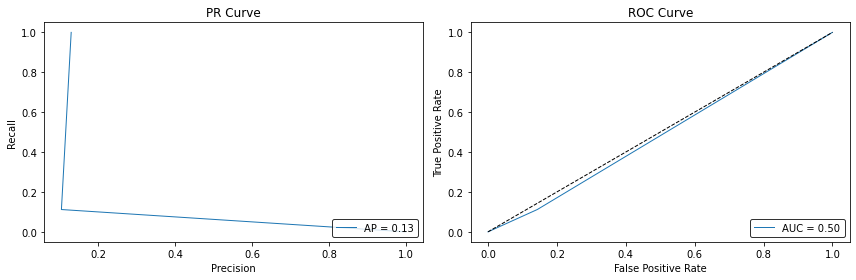

In [20]:
model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)
eval_model(model, X_val, y_val)

### Logistic regression

#### Without $\ell_1$ or $\ell_2$ penalty
We can consider this a second baseline. We use the `class_weight` parameter to help the model learning the minority class.

In [21]:
model = LogisticRegression(penalty="none", class_weight={0:1, 1:5})
param_grid = {'clf__C': [0.0001, 0.001],
              'feat_proc__max_corr': [0.8, 1],
              'feat_proc__k_num': [0.8, 1],
              'feat_proc__k_cat': [0.8, 1]
             }
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, fit_to_val=False)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=0.8, score=-0.572, total=   0.9s
[CV] clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=1, score=-0.571, total=   0.6s
[CV] clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=0.8, score=-0.572, total=   1.0s
[CV] clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   0.5s
[CV] clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=0.8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=0.8, score=-0.572, total=   0.9s
[CV] clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=1, score=-0.571, total=   0.5s
[CV] clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.3s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=0.8, score=-0.572, total=   0.9s
[CV] clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.2s remaining:    0.0s


[CV]  clf__C=0.0001, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   0.5s
[CV] clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.7s remaining:    0.0s


[CV]  clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=0.8, score=-0.572, total=   0.9s
[CV] clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.6s remaining:    0.0s


[CV]  clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=0.8, feat_proc__max_corr=1, score=-0.571, total=   0.6s
[CV] clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=0.8 
[CV]  clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=0.8, score=-0.572, total=   1.1s
[CV] clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=1 
[CV]  clf__C=0.001, feat_proc__k_cat=0.8, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   0.6s
[CV] clf__C=0.001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=0.8 
[CV]  clf__C=0.001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=0.8, score=-0.572, total=   0.9s
[CV] clf__C=0.001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=1 
[CV]  clf__C=0.001, feat_proc__k_cat=1, feat_proc__k_num=0.8, feat_proc__max_corr=1, score=-0.571, total=   0.5s
[CV] clf__C=0.001, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=0.8 
[CV] 

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   11.9s finished


In [22]:
pipe

Pipeline(steps=[('feat_proc', FeatureSelection(k_cat=0.8)),
                ('clf',
                 LogisticRegression(C=0.0001, class_weight={0: 1, 1: 5},
                                    penalty='none'))])

{'Log loss': 0.5707239866837518,
 'Brier score': 0.19234720494231455,
 'Average precision (PR-AUC)': 0.19100960039833872,
 'ROC-AUC': 0.5877410829600953,
 'EMC (C=1)': 1124,
 'EMC (C=5)': 2348,
 'EMC (C=10)': 3878,
 'EMC (C=50)': 16118}

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3482
           1       0.21      0.41      0.27       519

    accuracy                           0.72      4001
   macro avg       0.55      0.59      0.55      4001
weighted avg       0.81      0.72      0.75      4001



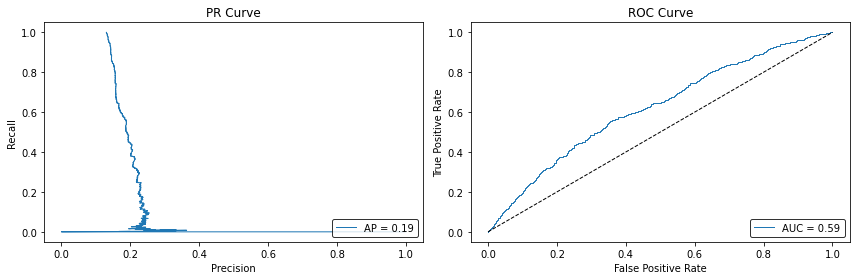

In [23]:
eval_model(pipe, X_val, y_val)

#### With $\ell_1$ penalty (LASSO)

Here we use $\ell_1$ penalty. We find that our feature selection pipeline (considered a "filter" method) is unecessary when paired with $\ell_1$ regularization (considered an "embedded" method), so we do not use our feature selection pipeline -- i.e. we set the parameters to 1.

In [24]:
model = LogisticRegression(penalty="l1", solver="liblinear", class_weight={0:1, 1:5})
param_grid = {'clf__C': [0.01, 0.1, 1],
              'feat_proc__max_corr': [1],
              'feat_proc__k_num': [1],
              'feat_proc__k_cat': [1]
             }
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, fit_to_val=False)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] clf__C=0.01, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.01, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   0.4s
[CV] clf__C=0.1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__C=0.1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.570, total=   0.8s
[CV] clf__C=1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__C=1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   9.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.0s finished


In [25]:
pipe

Pipeline(steps=[('feat_proc', FeatureSelection()),
                ('clf',
                 LogisticRegression(C=0.1, class_weight={0: 1, 1: 5},
                                    penalty='l1', solver='liblinear'))])

{'Log loss': 0.5703732316224491,
 'Brier score': 0.19229114874627118,
 'Average precision (PR-AUC)': 0.19145563512138528,
 'ROC-AUC': 0.5863469049192157,
 'EMC (C=1)': 1128,
 'EMC (C=5)': 2356,
 'EMC (C=10)': 3891,
 'EMC (C=50)': 16171}

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      3482
           1       0.21      0.41      0.27       519

    accuracy                           0.72      4001
   macro avg       0.55      0.59      0.55      4001
weighted avg       0.81      0.72      0.75      4001



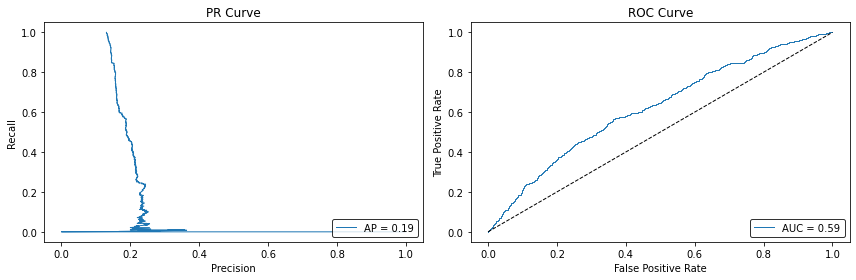

In [26]:
eval_model(pipe, X_val, y_val)

Results across all metrics are very similar to the previous logistic regression model.

Let's inspect the coefficients.

In [27]:
x = np.round(pipe["clf"].coef_, 3).reshape(-1)
y = pipe['feat_proc'].all_cols
pd.DataFrame({"feature":y, "coef":x}).sort_values("coef", ascending=False)

,feature,coef
68,zip_code,0.608
64,loan_amnt,0.186
117,total_bal_ex_mort,0.171
114,percent_bc_gt_75,0.149
69,dti,0.145
...,...,...
104,num_il_tl,-0.115
100,num_actv_bc_tl,-0.136
72,fico_range_low,-0.161
119,total_il_high_credit_limit,-0.260


We can see `zip_code` is extremely important. Note: we may want to be concerned of overfitting since this was a feature we used target encoding on. Higher values for loan amount, total credit balance excluding mortgage, and DTI all correspond to increase chance of default. In particular, a 1 unit increase in DTI corresponds to a $e^(0.145) = 1.15$ times increase in likelihood of default.

For negative coefficients, we see borrowers with higher annual income and higher credit score are less likely to default.

### KNN
Since KNN does not ahve a `class_weight` parameter, we use random undersampling to help it learn the minority class.

In [35]:
model = KNeighborsClassifier()
param_grid = {'feat_proc__max_corr': [0.6, 1],
              'feat_proc__k_num': [0.6, 1],
              'feat_proc__k_cat': [0.6, 1],
              'clf__n_neighbors': [10]
             }
sm = RandomUnderSampler(sampling_strategy=0.8) # if sampling strategy is float then it represents #minority/#majority
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, sm=sm, fit_to_val=False)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV] clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=0.6, feat_proc__max_corr=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=0.6, feat_proc__max_corr=0.6, score=-0.668, total=   2.1s
[CV] clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=0.6, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=0.6, feat_proc__max_corr=1, score=-0.721, total=   2.3s
[CV] clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=1, feat_proc__max_corr=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=1, feat_proc__max_corr=0.6, score=-0.714, total=   2.4s
[CV] clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=0.6, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.649, total=   2.9s
[CV] clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=0.6, feat_proc__max_corr=0.6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.6s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=0.6, feat_proc__max_corr=0.6, score=-0.718, total=   2.8s
[CV] clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=0.6, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=0.6, feat_proc__max_corr=1, score=-0.668, total=   3.0s
[CV] clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=0.6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.3s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=0.6, score=-0.711, total=   3.1s
[CV] clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.5s remaining:    0.0s


[CV]  clf__n_neighbors=10, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.677, total=   3.8s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.2s finished


In [36]:
pipe

Pipeline(steps=[('feat_proc', FeatureSelection(k_cat=0.6)),
                ('sampling', RandomUnderSampler(sampling_strategy=0.8)),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

{'Log loss': 0.6681039375199911,
 'Brier score': 0.21979255186203447,
 'Average precision (PR-AUC)': 0.15099317656290914,
 'ROC-AUC': 0.5341384095911923,
 'EMC (C=1)': 1189,
 'EMC (C=5)': 2629,
 'EMC (C=10)': 4429,
 'EMC (C=50)': 18829}

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3482
           1       0.16      0.31      0.21       519

    accuracy                           0.70      4001
   macro avg       0.52      0.53      0.51      4001
weighted avg       0.79      0.70      0.74      4001



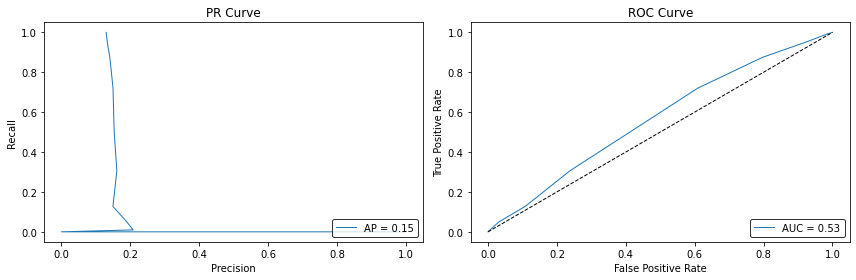

In [37]:
eval_model(pipe, X_val, y_val)

The KNN model performs worse on all metrics.

### Random forest
We again use the `class_weight` parameter. When doing grid search with random forest we found that decreasing `feat_proc_k_cat` (i.e. removing a higher fraction of categorical features) lead to better performance. We also found that a higher `class_weight` for the minority class was needed -- compared to logistic regression -- for the RF model to learn the minority class.

In [47]:
model = RandomForestClassifier(class_weight={0:1, 1:20})
param_grid = {'feat_proc__max_corr': [1],
              'feat_proc__k_num': [1],
              'feat_proc__k_cat': [0.5],
              'clf__n_estimators': [100, 150],
              'clf__max_depth': [10, 20],
              'clf__min_samples_split': [2]
             }
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, fit_to_val=False)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=100, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=100, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.853, total=   3.0s
[CV] clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=150, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=150, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.845, total=   4.3s
[CV] clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=100, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV]  clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=100, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.496, total=   4.3s
[CV] clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=150, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s


[CV]  clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=150, feat_proc__k_cat=0.5, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.491, total=   6.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.8s finished


In [50]:
pipe

Pipeline(steps=[('feat_proc', FeatureSelection(k_cat=0.5)),
                ('clf',
                 RandomForestClassifier(class_weight={0: 1, 1: 20},
                                        max_depth=20, n_estimators=150))])

{'Log loss': 0.49444355125040323,
 'Brier score': 0.15774611922246945,
 'Average precision (PR-AUC)': 0.17821162403249632,
 'ROC-AUC': 0.5475008272657953,
 'EMC (C=1)': 879,
 'EMC (C=5)': 2471,
 'EMC (C=10)': 4461,
 'EMC (C=50)': 20381}

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3482
           1       0.20      0.23      0.22       519

    accuracy                           0.78      4001
   macro avg       0.54      0.55      0.54      4001
weighted avg       0.79      0.78      0.79      4001



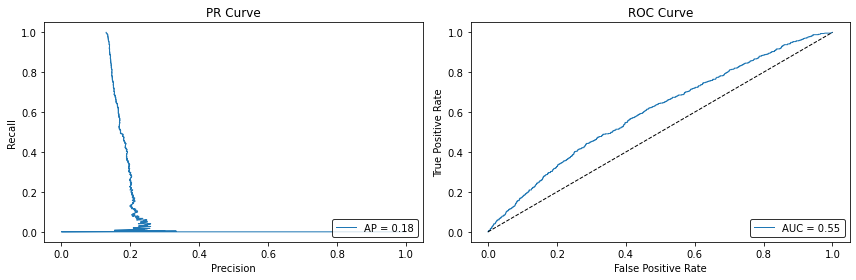

In [51]:
eval_model(pipe, X_val, y_val)

Performance seems to be slightly worse than the logistic regression model.

### XGBoost
Since XGBoost has a lot of *important* parameters, we use `RandomizedSearchCV` rather than `GridSearchCV`. A better method would be to use an optimized hyperparameter-optimization package like "hypopt".

In [60]:
model = XGBClassifier(learning_rate=0.02, objective='binary:logistic', scale_pos_weight=5)
param_grid = {'feat_proc__max_corr': [1],
              'feat_proc__k_num': [1],
              'feat_proc__k_cat': [1],
              'clf__min_child_weight': [1, 5, 10],
              'clf__gamma': [0.5, 1, 1.5, 2, 5],
              'clf__subsample': [0.6, 0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              'clf__max_depth': [3, 4, 5]
             }

pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, fit_to_val=False, random=True)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=2, clf__colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:56:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=2, clf__colsample_bytree=0.6, score=-0.559, total=   2.0s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=1.5, clf__colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[17:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=1.5, clf__colsample_bytree=0.6, score=-0.559, total=   2.0s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=1.0, clf__min_child_weight=5, clf__max_depth=4, clf__gamma=1, clf__colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[17:57:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=1.0, clf__min_child_weight=5, clf__max_depth=4, clf__gamma=1, clf__colsample_bytree=0.8, score=-0.579, total=   1.8s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=3, clf__gamma=1, clf__colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[17:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=5, clf__max_depth=3, clf__gamma=1, clf__colsample_bytree=0.6, score=-0.577, total=   1.5s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=10, clf__max_depth=3, clf__gamma=2, clf__colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[17:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=10, clf__max_depth=3, clf__gamma=2, clf__colsample_bytree=1.0, score=-0.582, total=   1.8s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=1.0, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=1.5, clf__colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.9s remaining:    0.0s


[17:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=1.0, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=1.5, clf__colsample_bytree=1.0, score=-0.576, total=   4.3s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.8, clf__min_child_weight=1, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.3s remaining:    0.0s


[17:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.8, clf__min_child_weight=1, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8, score=-0.566, total=   2.7s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=1, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.0s remaining:    0.0s


[17:57:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=1, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8, score=-0.565, total=   2.5s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=10, clf__max_depth=3, clf__gamma=1.5, clf__colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.5s remaining:    0.0s


[17:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.6, clf__min_child_weight=10, clf__max_depth=3, clf__gamma=1.5, clf__colsample_bytree=1.0, score=-0.582, total=   3.7s
[CV] feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.8, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.2s remaining:    0.0s


[17:57:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  feat_proc__max_corr=1, feat_proc__k_num=1, feat_proc__k_cat=1, clf__subsample=0.8, clf__min_child_weight=5, clf__max_depth=5, clf__gamma=0.5, clf__colsample_bytree=0.8, score=-0.567, total=   2.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.5s finished


[17:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
pipe

Pipeline(steps=[('feat_proc', FeatureSelection()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=2, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.02,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
                               subsample=0.6, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

{'Log loss': 0.5590644733767544,
 'Brier score': 0.18727757737562792,
 'Average precision (PR-AUC)': 0.18599309052378654,
 'ROC-AUC': 0.5711755695960176,
 'EMC (C=1)': 1011,
 'EMC (C=5)': 2395,
 'EMC (C=10)': 4125,
 'EMC (C=50)': 17965}

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3482
           1       0.21      0.33      0.25       519

    accuracy                           0.75      4001
   macro avg       0.55      0.57      0.55      4001
weighted avg       0.80      0.75      0.77      4001



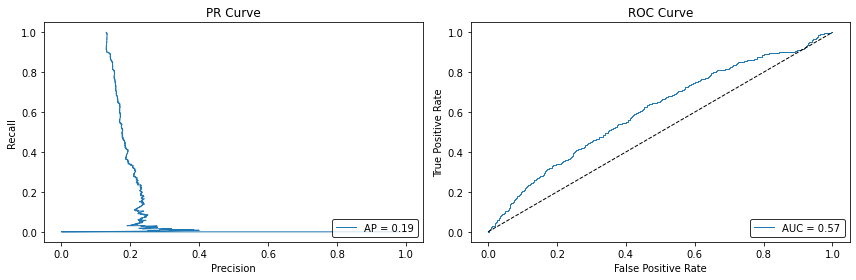

In [62]:
eval_model(pipe, X_val, y_val)

Performance is better than the random forest model but slightly worse than the logistic regression model.

### Neural network

In [64]:
model = MLPClassifier() 
param_grid = {'feat_proc__max_corr': [0.75],
              'feat_proc__k_num': [0.75],
              'feat_proc__k_cat': [0.75],
              'clf__alpha': [0.1, 1], # higher alpha <--> higher regularization
              'clf__hidden_layer_sizes': [(32,), (32,32), (64,)]
             }
sm = RandomUnderSampler(sampling_strategy=0.5)             
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, sm=sm, fit_to_val=False)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] clf__alpha=0.1, clf__hidden_layer_sizes=(32,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__alpha=0.1, clf__hidden_layer_sizes=(32,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-0.631, total=   5.9s
[CV] clf__alpha=0.1, clf__hidden_layer_sizes=(32, 32), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  clf__alpha=0.1, clf__hidden_layer_sizes=(32, 32), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-1.004, total=   8.4s
[CV] clf__alpha=0.1, clf__hidden_layer_sizes=(64,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s


[CV]  clf__alpha=0.1, clf__hidden_layer_sizes=(64,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-0.733, total=   8.1s
[CV] clf__alpha=1, clf__hidden_layer_sizes=(32,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s


[CV]  clf__alpha=1, clf__hidden_layer_sizes=(32,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-0.516, total=   5.8s
[CV] clf__alpha=1, clf__hidden_layer_sizes=(32, 32), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.0s remaining:    0.0s


[CV]  clf__alpha=1, clf__hidden_layer_sizes=(32, 32), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-0.656, total=   9.1s
[CV] clf__alpha=1, clf__hidden_layer_sizes=(64,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.1s remaining:    0.0s


[CV]  clf__alpha=1, clf__hidden_layer_sizes=(64,), feat_proc__k_cat=0.75, feat_proc__k_num=0.75, feat_proc__max_corr=0.75, score=-0.528, total=   7.9s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   45.0s finished


In [66]:
pipe

Pipeline(steps=[('feat_proc',
                 FeatureSelection(k_cat=0.75, k_num=0.75, max_corr=0.75)),
                ('sampling', RandomUnderSampler(sampling_strategy=0.5)),
                ('clf', MLPClassifier(alpha=1, hidden_layer_sizes=(32,)))])

{'Log loss': 0.5193208273720131,
 'Brier score': 0.16957497566746987,
 'Average precision (PR-AUC)': 0.18075962162652817,
 'ROC-AUC': 0.5443494702732135,
 'EMC (C=1)': 998,
 'EMC (C=5)': 2522,
 'EMC (C=10)': 4427,
 'EMC (C=50)': 19667}

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3482
           1       0.18      0.27      0.22       519

    accuracy                           0.75      4001
   macro avg       0.53      0.54      0.53      4001
weighted avg       0.79      0.75      0.77      4001



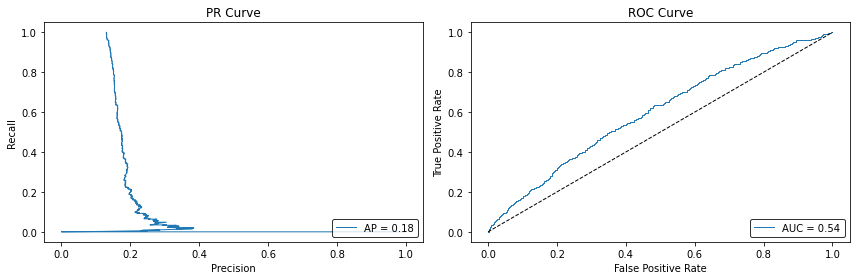

In [67]:
eval_model(pipe, X_val, y_val)

## Best model & testing performance

We think the logistic regression with $\ell_1$ penalty is most appropriate. The more complex models performed either worse or only slightly better -- in some metrics -- than the logistic regression model. The logistic regression model also has the advantage that it is interpretable. 

Let's compare the validation and test performance of this model.

In [71]:
model = LogisticRegression(penalty="l1", solver="liblinear", class_weight={0:1, 1:5})
param_grid = {'clf__C': [0.01, 0.1, 1],
              'feat_proc__max_corr': [1],
              'feat_proc__k_num': [1],
              'feat_proc__k_cat': [1]
             }
pipe = fit_model(model, param_grid, X_train, y_train, X_val, y_val, fit_to_val=False)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] clf__C=0.01, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.01, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=   0.4s
[CV] clf__C=0.1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__C=0.1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.570, total=   0.8s
[CV] clf__C=1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  clf__C=1, feat_proc__k_cat=1, feat_proc__k_num=1, feat_proc__max_corr=1, score=-0.571, total=  12.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s finished


{'Log loss': 0.5703741250837382,
 'Brier score': 0.1922918413805672,
 'Average precision (PR-AUC)': 0.19144871313949435,
 'ROC-AUC': 0.586203309284523,
 'EMC (C=1)': 1129,
 'EMC (C=5)': 2357,
 'EMC (C=10)': 3892,
 'EMC (C=50)': 16172}

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3482
           1       0.21      0.41      0.27       519

    accuracy                           0.72      4001
   macro avg       0.55      0.59      0.55      4001
weighted avg       0.81      0.72      0.75      4001



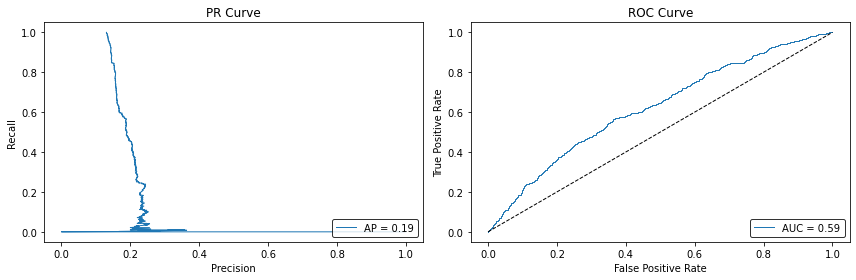

In [72]:
eval_model(pipe, X_val, y_val)

{'Log loss': 0.4966579302134005,
 'Brier score': 0.15980099660453595,
 'Average precision (PR-AUC)': 0.23327980982867413,
 'ROC-AUC': 0.5488591137072814,
 'EMC (C=1)': 19542,
 'EMC (C=5)': 65550,
 'EMC (C=10)': 123060,
 'EMC (C=50)': 583140}

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     75326
           1       0.27      0.20      0.23     14458

    accuracy                           0.78     89784
   macro avg       0.56      0.55      0.55     89784
weighted avg       0.76      0.78      0.77     89784



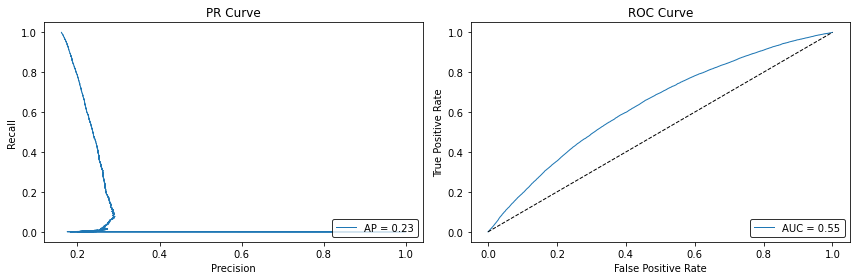

In [73]:
eval_model(pipe, X_test, y_test)

In [76]:
print("Frequency of defaulters in val. set:", np.mean(y_val))
print("Frequency of defaulters in test set:", np.mean(y_test))

Frequency of defaulters in val. set: 0.12971757060734818
Frequency of defaulters in test set: 0.16103091864920252


Our model predicts the minority class a lot more often in the test set, despite default rates having increased for the test set.  One possible way to fix this is to make numeric variables relative to each time period (we're kind of already doing this for the training set since we used `StandardScaler`, but not for the testing set). For example, we could take each credit score in the (2016Q1) and subtract off the mean credit score in 2015Q4. Due to time constrants, we'll leave this for future work.

Let's save the best model.

In [85]:
pickle.dump(pipe, open("logistic_best.pkl", 'wb'))

## Value added

It is hard to estimate the monetary value added from our model because the cost of misclassification is unclear. Generally, accepting a bad loan (false negative) will cost more than rejecting a good loan (false positive), but whether this cost ratio is 5:1, 10:1, 20:1 etc. is unclear. If we knew the relative costs of misclassification, we could use metrics from the field of "cost-sensitive machine learning" (http://web.cs.iastate.edu/~honavar/elkan.pdf). 

A false negative means that the loan will default and while we can easily approximate this loss from the data, there is also a large opportunity cost which is hard to estimate. What alternative would we have taken if we correctly rejected this loan? Would we have used our model again and then found a "good" borrower? 

Estimating the cost from a false positive (rejecting a good loan) is also hard to estimate. For one, too many false positives will slow the growth of the LendingClub platform -- so there is some cost here. Secondly, it is again not clear what alternative would be taken after rejecting the loan -- will the lender find a good borrower, a bad borrower, or no borrower at all?

In practice, I think the only way to suggest our model is if it outperforms current models according to the machine learning metrics we've used.

In [ ]:
# def calc_value_added(y, y_pred, profit, c=1):
#     TP = np.where(np.logical_and(y_pred == 1, y == 1)) # true positive
#     FP = np.where(np.logical_and(y_pred == 1, y == 0)) # false positive
#     value_added = - np.sum(profit[TP]) - ((len(TP)+len(FP))/len(profit))**c*np.sum(profit[FP])
#     rel_value_added = (value_added + np.sum(profit))/np.sum(profit)
    
#     # #     two functional forms (polynomial & exponential)
# #     c_list = np.linspace(0,1,51)
# #     value_added = np.array([-np.sum(profit[TP])-((len(TP)+len(FP))/len(profit))**c*np.sum(profit[FP]) for c in c_list])
# # #     value_added = np.array([-np.sum(profit[TP])-np.exp(-c*(1-(len(TP)+len(FP))/len(profit)))*np.sum(profit[FP]) for c in c_list])
# #     plt.plot(c_list, value_added)
    
#     return value_added, rel_value_added

# def make_value_added_curve(y, y_proba, c=1):
#     VAs = []
#     thresholds = np.linspace(0,1,51)
#     for thr in thresholds:
#         y_pred = y_proba.copy()
#         y_pred[y_pred > thr] = 1
#         y_pred[y_pred <= thr] = 0
#         VA, rel_VA = calc_value_added(y, y_pred, profit, c)
#         VAs.append(VA)
#     plt.plot(thresholds, VAs)
#     plt.xlabel("Threshold")
#     plt.ylabel("Value added")
#     plt.show()
    
# def make_value_added_region(y, y_proba, profit)    
#     # Value added
#     VAs = []
#     thresholds = np.linspace(0,1,51)
#     c_list = np.linspace(0,0.1,21)
#     for thr in thresholds:
#         y_pred = y_proba.copy()
#         y_pred[y_pred > thr] = 1
#         y_pred[y_pred <= thr] = 0
#         TP = np.where(np.logical_and(y_pred == 1, y == 1)) # true positive
#         FP = np.where(np.logical_and(y_pred == 1, y == 0)) # false positive
#         VA = np.array([-np.sum(profit[TP])-((len(TP)+len(FP))/len(profit))**c*np.sum(profit[FP]) for c in c_list])
#         VAs.append(VA)
    
#     VAs = np.array(VAs)
#     VAs = np.ma.masked_where(VAs <= 0, VAs)
    
#     plt.figure(figsize=(5,8))
#     plt.imshow(VAs, origin="lower", interpolation="bilinear")
#     plt.xticks(np.arange(len(c_list))[::5], c_list[::5])
#     plt.xlabel(r"$c$")
#     plt.yticks(np.arange(len(thresholds))[::5], np.round(thresholds[::5],1)) 
#     plt.ylabel("Threshold")
#     plt.colorbar()